In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### 3. train/valid/test split

In [2]:
%%time
import zipfile
import requests
import os
import io
from urllib.parse import urlencode

# public_key = "https://disk.yandex.ru/d/GHFPakrPFt1JVQ"
public_key = "https://disk.yandex.ru/d/p-yNGHbQ0mi7EQ"
folder_name = "Архив"
asset_zip_path = os.path.join(os.getcwd(), f"{folder_name}.zip")

def download_and_unzip(load_from):
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

  # Получаем загрузочную ссылку
  final_url = base_url + urlencode(dict(public_key=load_from))
  try:
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    print('Success! The data has been loaded')
  except:
    "Could not load the content of the URL"

  print("Unpacking the data...")
  try:
    extract_to = os.getcwd()

    z = zipfile.ZipFile(io.BytesIO(download_response.content))
    z.extractall(extract_to)
    print(f'Done! The data is available here {extract_to}')
  except:
    "Error occured while extracting the data"

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(public_key)

Success! The data has been loaded
Unpacking the data...
Done! The data is available here /content
CPU times: user 3.98 s, sys: 1.34 s, total: 5.32 s
Wall time: 19.7 s


In [3]:
df_1min = load_pkl('./data/data_shift_time_1min.pkl')
df_5min = load_pkl('./data/data_shift_time_5min.pkl')
df_1hour = load_pkl('./data/data_shift_time_1hour.pkl')
df_1day = load_pkl('./data/data_shift_time_1day.pkl')

# df_1min = load_pkl('experiments/model_one_fc/data/data_shift_time_1min.pkl')
# df_5min = load_pkl('experiments/model_one_fc/data/data_shift_time_5min.pkl')
# df_1hour = load_pkl('experiments/model_one_fc/data/data_shift_time_1hour.pkl')
# df_1day = load_pkl('experiments/model_one_fc/data/data_shift_time_1day.pkl')


In [4]:
df_1min.head()

,time,open,close,volume,low,high,ticker,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,index_start_1day,result,delta_time
0,2022-10-03 10:01:00,219.00,219.93,87793.0,218.00,220.25,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:04:00
1,2022-10-03 10:02:00,219.80,220.80,61549.0,219.70,220.55,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:01:00
2,2022-10-03 10:03:00,220.24,219.34,52640.0,219.20,220.38,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:03:00
3,2022-10-03 10:04:00,219.17,218.96,61506.0,217.70,219.40,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:02:00
4,2022-10-03 10:05:00,218.82,218.30,51464.0,217.76,218.96,GAZP,0,0.0,0,NaN,NaN,NaN,NaN,LOSE,0 days 00:07:00


In [5]:
df_5min.head()

,time,open_5min,close_5min,volume_5min,low_5min,high_5min,ticker
0,2022-10-03 10:05:00,219.00,218.30,314952.0,217.70,220.55,GAZP
1,2022-10-03 10:10:00,218.30,218.50,182525.0,216.19,218.78,GAZP
2,2022-10-03 10:15:00,218.11,215.86,193758.0,215.31,218.13,GAZP
3,2022-10-03 10:20:00,215.83,216.85,91747.0,215.70,217.39,GAZP
4,2022-10-03 10:25:00,216.85,216.58,52824.0,216.40,217.16,GAZP


In [6]:
df_1hour.head()

,time,open_1hour,close_1hour,volume_1hour,low_1hour,high_1hour,ticker
0,2022-10-03 11:00:00,219.00,215.80,1623411.0,213.63,220.55,GAZP
1,2022-10-03 12:00:00,215.80,216.36,411786.0,214.96,216.78,GAZP
2,2022-10-03 13:00:00,216.34,215.88,237084.0,215.43,216.43,GAZP
3,2022-10-03 14:00:00,215.85,217.10,573509.0,215.53,217.77,GAZP
4,2022-10-03 15:00:00,217.12,216.94,364609.0,216.50,217.49,GAZP


In [7]:
df_1day.head()

,time,open_1day,close_1day,volume_1day,low_1day,high_1day,ticker
0,2022-09-30 23:50:00,231.68,217.70,24588842.0,189.42,238.72,GAZP
1,2022-10-03 23:50:00,219.00,215.83,5070201.0,213.63,220.55,GAZP
2,2022-10-04 23:50:00,216.48,210.72,4975859.0,208.80,216.70,GAZP
3,2022-10-05 23:50:00,211.50,209.50,5322122.0,202.85,211.50,GAZP
4,2022-10-06 23:50:00,210.00,212.86,5165564.0,209.60,216.88,GAZP


### Normalization data

In [8]:
from sklearn.preprocessing import StandardScaler

cols = ['open', 'close', 'volume', 'low', 'high']
scaler = StandardScaler()
df_1min[cols] = scaler.fit_transform(df_1min[cols])

cols = ['open_5min', 'close_5min', 'volume_5min', 'low_5min', 'high_5min']
scaler = StandardScaler()
df_5min[cols] = scaler.fit_transform(df_5min[cols])

cols = ['open_1hour', 'close_1hour', 'volume_1hour', 'low_1hour', 'high_1hour']
scaler = StandardScaler()
df_1hour[cols] = scaler.fit_transform(df_1hour[cols])

cols = ['open_1day', 'close_1day', 'volume_1day', 'low_1day', 'high_1day']
scaler = StandardScaler()
df_1day[cols] = scaler.fit_transform(df_1day[cols])

In [9]:
df_1min['target'] = (df_1min['result'] == 'WIN').astype(int)

<ipython-input-10-196b51a17f13>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_1min[['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.count().plot.bar()


<Axes: xlabel='time'>

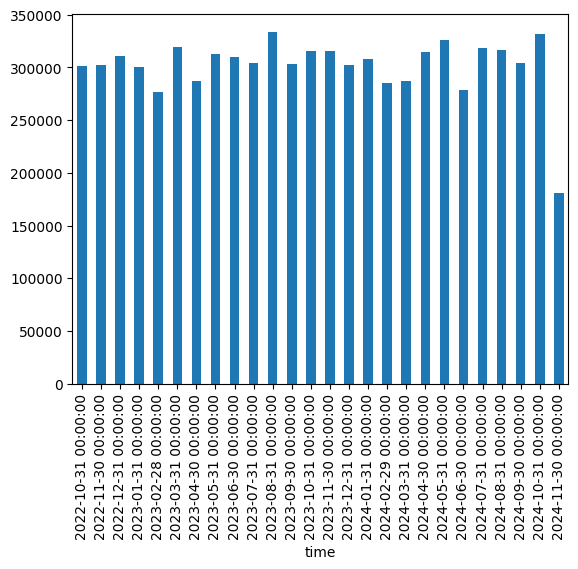

In [10]:
df_1min[['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.count().plot.bar()

<ipython-input-11-3d23f5904986>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_1min[['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.mean().plot.bar()


<Axes: xlabel='time'>

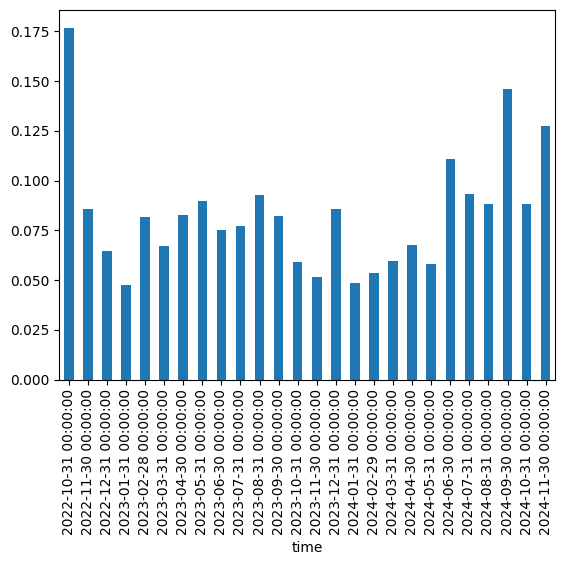

In [11]:
df_1min[['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.mean().plot.bar()

In [12]:
#в 2024 году - 248 рабочих дней, возьмем длину последовательности данных 200 (и так будет долго учиться)

![](imoex.png)

In [13]:
mask_train = np.array((pd.Timestamp('2023-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-11-19')))

In [14]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(2453935, 597323, 620944, 497823)

In [15]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

4170025

In [16]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.5884700931049575,
 0.14324206689408336,
 0.14890654132768988,
 0.11938129867326934)

In [17]:
df_1min.loc[mask_train, 'target'].mean(), df_1min.loc[mask_valid, 'target'].mean(), df_1min.loc[mask_test, 'target'].mean(), df_1min.loc[mask_test2, 'target'].mean()

(0.06044455130229611,
 0.10156816328853903,
 0.11664175835502075,
 0.10381199743684)

In [18]:
#проверки

In [19]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

True

<ipython-input-20-05e394993a2f>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_1min.loc[mask_data, ['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.count().plot.bar()


<Axes: xlabel='time'>

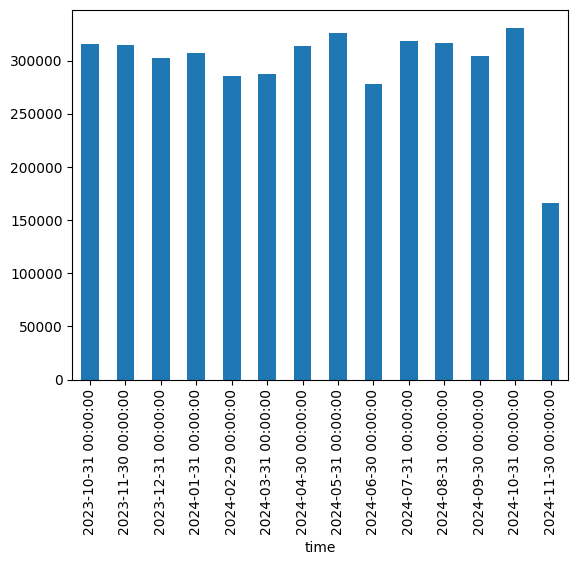

In [20]:
df_1min.loc[mask_data, ['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.count().plot.bar()

In [21]:
#indexes

inds_train = df_1min.index[mask_train].values
inds_valid = df_1min.index[mask_valid].values
inds_test = df_1min.index[mask_test].values
inds_test2 = df_1min.index[mask_test2].values

In [22]:
inds_train

array([ 208476,  208477,  208478, ..., 7752162, 7752163, 7752164])

In [23]:
#проверим, что все индексы валидны
#у каждой точки должно быть 200 точек назад (минут, 5минут, часов, дней)

In [24]:
df_1min.head()

,time,open,close,volume,low,high,ticker,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,index_start_1day,result,delta_time,target
0,2022-10-03 10:01:00,-0.599164,-0.598683,12.888418,-0.599620,-0.598569,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:04:00,0
1,2022-10-03 10:02:00,-0.598751,-0.598234,8.946152,-0.598742,-0.598414,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:01:00,0
2,2022-10-03 10:03:00,-0.598524,-0.598987,7.607878,-0.599000,-0.598502,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:03:00,0
3,2022-10-03 10:04:00,-0.599076,-0.599183,8.939692,-0.599774,-0.599008,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:02:00,0
4,2022-10-03 10:05:00,-0.599256,-0.599524,7.431224,-0.599743,-0.599235,GAZP,0,0.0,0,NaN,NaN,NaN,NaN,LOSE,0 days 00:07:00,0


In [25]:
def check_valid_inds(inds, df_1min, len_seq=200):
    ind_1min_start = df_1min.loc[inds, 'index_1min_start'].values.astype(int)
    ind_1min_end = inds.astype(int)
    assert (~np.isnan(ind_1min_start)).all() & (~np.isnan(ind_1min_end)).all() &\
                                               ((ind_1min_end - ind_1min_start + 1) >= len_seq).all(), 'Error: 1min'

    ind_5min_start = df_1min.loc[inds, 'index_start_5min'].values.astype(int)
    ind_5min_end = df_1min.loc[inds, 'index_5min'].values.astype(int)
    assert (~np.isnan(ind_5min_start)).all() & (~np.isnan(ind_5min_end)).all() &\
                                                ((ind_5min_end - ind_5min_start + 1) >= len_seq).all(), 'Error: 5min'

    ind_1hour_start = df_1min.loc[inds, 'index_start_1hour'].values.astype(int)
    ind_1hour_end = df_1min.loc[inds, 'index_1hour'].values.astype(int)
    assert (~np.isnan(ind_1hour_start)).all() & (~np.isnan(ind_1hour_end)).all() &\
                                                ((ind_1hour_end - ind_1hour_start + 1) >= len_seq).all(), 'Error: 1hour'

    ind_1day_start = df_1min.loc[inds, 'index_start_1day'].values.astype(int)
    ind_1day_end = df_1min.loc[inds, 'index_1day'].values.astype(int)
    assert (~np.isnan(ind_1day_start)).all() & (~np.isnan(ind_1day_end)).all() &\
                                                ((ind_1day_end - ind_1day_start + 1) >= len_seq).all(), 'Error: 1day'

    return 'All Good'


In [26]:
check_valid_inds(inds_train, df_1min, len_seq=200)

'All Good'

In [27]:
check_valid_inds(inds_valid, df_1min, len_seq=200)

'All Good'

In [28]:
check_valid_inds(inds_test, df_1min, len_seq=200)

'All Good'

In [29]:
check_valid_inds(inds_test2, df_1min, len_seq=200)

'All Good'

### 4. Model Four

In [30]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [31]:
df_1min['ticker_code'] = df_1min['ticker'].astype('category').cat.codes

In [32]:
df_1min['ticker_code'].value_counts()

,count
ticker_code,
2,447059
11,446997
13,446747
4,444970
9,443270
15,442772
5,442355
0,442155
1,440282


In [33]:
df_1min['ticker_code'].max()

17

In [34]:
df_1min['ticker'].value_counts()

,count
ticker,
GAZP,447059
ROSN,446997
SBER,446747
LKOH,444970
NVTK,443270
TATN,442772
MAGN,442355
ALRS,442155
CHMF,440282


In [35]:
dict(enumerate(df_1min['ticker'].astype('category').cat.categories))

{0: 'ALRS',
 1: 'CHMF',
 2: 'GAZP',
 3: 'GMKN',
 4: 'LKOH',
 5: 'MAGN',
 6: 'MGNT',
 7: 'MTSS',
 8: 'NLMK',
 9: 'NVTK',
 10: 'OZON',
 11: 'ROSN',
 12: 'RUAL',
 13: 'SBER',
 14: 'SNGS',
 15: 'TATN',
 16: 'TCSG',
 17: 'YDEX'}

#### 4.1 PyDataset

In [36]:
class CandleData:
    def __init__(self, df_1min, df_5min, df_1hour, df_1day):
        self.df_1min = df_1min
        self.df_5min = df_5min
        self.df_1hour = df_1hour
        self.df_1day = df_1day
        self.make_np_arr_data()

    def make_np_arr_data(self):
        #time
        time_cyclic = (self.df_1min['time'] - pd.to_datetime(self.df_1min['time'].dt.date) - pd.Timedelta('10:01:00')) / pd.Timedelta('13:49:00')
        self.df_1min['sin_time'] = np.sin(time_cyclic * 2 * np.pi)
        self.df_1min['cos_time'] = np.cos(time_cyclic * 2 * np.pi)

        day_of_week_cyclic = np.minimum(self.df_1min['time'].dt.dayofweek, 4) / 4
        self.df_1min['sin_day'] = np.sin(day_of_week_cyclic * 2 * np.pi)
        self.df_1min['cos_day'] = np.cos(day_of_week_cyclic * 2 * np.pi)

        #1min
        cols_arr_1min = ['sin_time', 'cos_time', 'sin_day', 'cos_day',
                         'open', 'close', 'volume', 'low', 'high']
        self.arr_1min = np.array(self.df_1min[cols_arr_1min])

        #cols index_slice
        cols_index_time_slice = ['index_1min_start',
                         'index_5min', 'index_start_5min',
                         'index_1hour', 'index_start_1hour',
                         'index_1day', 'index_start_1day']
        self.index_time_slice_1min = np.array(self.df_1min[cols_index_time_slice])

        #cols ticker
        self.ticker_code_1min = np.array(self.df_1min['ticker_code'])

        #5min
        cols_arr_5min = ['open_5min', 'close_5min', 'volume_5min', 'low_5min', 'high_5min']
        self.arr_5min = np.array(self.df_5min[cols_arr_5min])

        #1hour
        cols_arr_1hour = ['open_1hour', 'close_1hour', 'volume_1hour', 'low_1hour', 'high_1hour']
        self.arr_1hour = np.array(self.df_1hour[cols_arr_1hour])

        #1day
        cols_arr_1day = ['open_1day', 'close_1day', 'volume_1day', 'low_1day', 'high_1day']
        self.arr_1day = np.array(self.df_1day[cols_arr_1day])

        #target
        self.target_1min = df_1min['target'].values


class dataset(tf.keras.utils.PyDataset):

    def __init__(self, data, inds, count_samples=None, len_seq=200,  batch_size=32, shuffle=False, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.inds = inds
        self.len_seq = len_seq
        self.batch_size = batch_size

        self.count_samples = count_samples
        if self.count_samples is not None:
            self.inds = np.random.RandomState(seed=42).permutation(self.inds)

        self.shuffle = shuffle
        if self.shuffle:
            self.inds = np.random.permutation(self.inds)

    def __len__(self):
        # Return number of batches.
        if self.count_samples is None:
            return math.ceil(len(self.inds) / self.batch_size)
        else:
            return math.ceil(self.count_samples / self.batch_size)

    def __getitem__(self, idx):
        # Return x, y for batch idx.
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.inds))
        batch_inds = self.inds[low:high]


        x_batch = []
        x_batch_ticker_code = []
        y_batch = []

        for i in batch_inds:
            # cols_index_time_slice = ['index_1min_start',
            #              'index_5min', 'index_start_5min',
            #              'index_1hour', 'index_start_1hour',
            #              'index_1day', 'index_start_1day']
            #1min
            ind_high_1min = i+1
            ind_low_1min = int(ind_high_1min - self.len_seq)
            tensor_1min = self.data.arr_1min[ind_low_1min:ind_high_1min, :]

            #5min
            ind_high_5min = int(self.data.index_time_slice_1min[i, 1] + 1)
            ind_low_5min = int(ind_high_5min - self.len_seq)
            tensor_5min = self.data.arr_5min[ind_low_5min:ind_high_5min, :]

            #1hour
            ind_high_1hour = int(self.data.index_time_slice_1min[i, 3] + 1)
            ind_low_1hour = int(ind_high_1hour - self.len_seq)
            tensor_1hour = self.data.arr_1hour[ind_low_1hour:ind_high_1hour, :]

            #1day
            ind_high_1day = int(self.data.index_time_slice_1min[i, 5] + 1)
            ind_low_1day =  int(ind_high_1day - self.len_seq)
            tensor_1day = self.data.arr_1day[ind_low_1day:ind_high_1day, :]

            #target
            y = self.data.target_1min[i]

            #ticker
            ticker_code = self.data.ticker_code_1min[i]


            x = np.concatenate((tensor_1min, tensor_5min, tensor_1hour, tensor_1day), axis=1)

            x_batch += [x]
            x_batch_ticker_code += [ticker_code]
            y_batch += [y]

        #return {'input_numeric':  np.array(x_batch), 'input_ticker' : np.array(x_batch_ticker_code)}, np.array(y_batch)
        return np.array(x_batch), np.array(y_batch)


    def on_epoch_end(self):
        if self.shuffle:
            self.inds = np.random.permutation(self.inds)

In [37]:
data = CandleData(df_1min, df_5min, df_1hour, df_1day)


dataset_train = dataset(data, inds_train, count_samples=64*10_000, len_seq=200, batch_size=64, shuffle=True)
dataset_valid = dataset(data, inds_valid, count_samples=64*2_000, len_seq=200, batch_size=64, shuffle=False)
dataset_test = dataset(data, inds_test, count_samples=64*2_000, len_seq=200, batch_size=64, shuffle=False)
dataset_test2 = dataset(data, inds_test2, count_samples=64*2_000, len_seq=200, batch_size=64, shuffle=False)

In [38]:
len(dataset_valid)

2000

In [39]:
# #
# dataset_train_subsample = dataset(data, inds_train, count_samples=1000, len_seq=200, batch_size=64, shuffle=True)
# dataset_valid_subsample = dataset(data, inds_valid, count_samples=1000, len_seq=200, batch_size=64, shuffle=True)
# dataset_test_subsample = dataset(data, inds_test, count_samples=1000, len_seq=200, batch_size=64, shuffle=True)
# dataset_test2_subsample = dataset(data, inds_test2, count_samples=1000, len_seq=200, batch_size=64, shuffle=False)

#### 4.2 Model

In [40]:
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D



def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])


def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=outputs)

In [41]:
dataset_train.__getitem__(0)[0][0].shape

(200, 24)

In [42]:
input_shape = (200,24)
head_size = 128#256
num_heads = 16#16
ff_dim = 512#1024
num_layers = 2#12
dropout = 0.1#0.2

model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 24)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 200, 24)        │             48 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 200, 24)        │        202,776 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 200, 24)        │              0 │ multi_head_attention[… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 200, 24)        │             48 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 200, 512)       │         12,800 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200, 512)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 200, 24)        │         12,312 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 200, 24)        │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 200, 24)        │             48 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 200, 24)        │        202,776 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 200, 24)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 200, 24)        │             48 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 200, 512)       │         12,800 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 200, 512)       │              0 │ dense_2[0][0]          │
├──────────────────────

 Total params: 456,041 (1.74 MB)

 Trainable params: 456,041 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

#### 4.3 WarmUpCosineDecay

In [43]:
from tensorflow import keras

def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    #learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))
    learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * tf.cast((global_step - warmup_steps - hold), tf.float32) / tf.cast(total_steps - warmup_steps - hold, tf.float32)))


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)

    return learning_rate


class WarmUpCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )
    def get_config(self):
        config = {
          'start_lr': self.start_lr,
          'target_lr': self.target_lr,
          'warmup_steps': self.warmup_steps,
          'total_steps': self.total_steps,
          'hold': self.hold
        }
        return config



#### 4.4 Callbacks

In [44]:
# метрики на конец эпохи

In [45]:
def get_y_true(data):
    return data.data.target_1min[data.inds[:len(data)*data.batch_size]]

def precision(y_true, y_pred, threshold):
    mask = y_pred.ravel() > threshold
    return mask.sum(), y_true.ravel()[mask].mean()



class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, datasets):
        self.datasets = datasets
        self.list_auc = []
        self.list_precision = []
        # self.list_percent = []
        # self.list_count = []
        super(MetricsCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):

        list_y_true = []
        list_y_pred = []

        list_auc = []
        list_precision = []
        # list_count = []
        # list_percent = []
        for dataset in self.datasets:
            y_true = get_y_true(dataset)
            y_pred = self.model.predict(dataset)

            list_auc += [roc_auc_score(y_true, y_pred)]
            threshold = np.quantile(y_pred, q=0.99)
            mask = y_pred.ravel() > threshold
            list_precision += [y_true.ravel()[mask].mean()]


#evaluate using one threshold
        # for dataset in self.datasets:
        #     y_true = get_y_true(dataset)
        #     y_pred = self.model.predict(dataset)

        #     list_y_true += [y_true]
        #     list_y_pred += [y_pred]


        # threshold = np.quantile(list_y_pred[1], q=0.99)

        # for y_true, y_pred in zip(list_y_true, list_y_pred):
        #     list_auc += [roc_auc_score(y_true, y_pred)]

        #     mask = y_pred.ravel() > threshold
        #     list_precision += [y_true.ravel()[mask].mean()]
        #     list_count += [mask.sum()]
        #     list_percent += [mask.mean()]

        # del list_y_true, list_y_pred
        # gc.collect()



        self.list_auc += [list_auc.copy()]
        self.list_precision += [list_precision.copy()]
        # self.list_percent += [list_percent.copy()]
        # self.list_count += [list_count.copy()]


        print('AUC_ROC: ', np.round(list_auc, decimals=3).tolist())
        # print('COUNT: ', np.round(list_count, decimals=3).tolist())
        # print('PERCENT: ', np.round(list_percent, decimals=3).tolist())
        print('PRECISION: ', np.round(list_precision, decimals=3).tolist())
        print()




#### 4.5 Train

In [ ]:
! mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
EPOCHS = 20

total_steps = len(dataset_train) * EPOCHS
warmup_steps = int(0.05*total_steps)
schedule = WarmUpCosineDecay(start_lr=0.0001, target_lr=0.001, warmup_steps=warmup_steps, total_steps=total_steps, hold=warmup_steps)
#may be changed to 1
optimizer=tf.keras.optimizers.Adam(learning_rate=schedule)
#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.keras.losses.BinaryCrossentropy()
metric_auc_roc = tf.keras.metrics.AUC(num_thresholds=256)


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metric_auc_roc])


#metrics_callback = MetricsCallback([dataset_train_subsample, dataset_valid_subsample, dataset_test_subsample, dataset_test2_subsample])
metrics_callback = MetricsCallback([dataset_train, dataset_valid, dataset_test, dataset_test2])
save_callback = tf.keras.callbacks.ModelCheckpoint( "./models/model_{epoch:04d}.keras", save_freq='epoch')
callbacks = [save_callback, metrics_callback]




In [ ]:
# lrs = [lr_warmup_cosine_decay(step, total_steps=total_steps, warmup_steps=warmup_steps, hold=warmup_steps, start_lr=0.0001,
#                            target_lr=0.005) for step in tqdm(np.arange(total_steps))]
# plt.plot(lrs)

In [ ]:
1

1

In [ ]:
model.fit(dataset_train, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 351s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step
AUC_ROC:  [0.825, 0.723, 0.746, 0.737]
PRECISION:  [0.402, 0.331, 0.354, 0.412]

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1646s 163ms/step - auc_1: 0.7184 - loss: 0.2521
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 352s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step
AUC_ROC:  [0.843, 0.727, 0.729, 0.704]
PRECISION:  [0.399, 0.31, 0.348, 0.347]

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1632s 163ms/step - auc_1: 0.8226 - loss: 0.1853
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 353s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step
AUC_ROC:  [0.872, 0.733, 0.744, 0.725]
PRECISION:  [0.51, 0.248, 0.366, 0.267]

10000/10000 ━━━

In [ ]:
df_auc = pd.DataFrame(metrics_callback.list_auc)
df_precision = pd.DataFrame(metrics_callback.list_precision)
# df_count = pd.DataFrame(metrics_callback.list_count)
# df_percent = pd.DataFrame(metrics_callback.list_percent)

In [ ]:
#df_count

In [ ]:
df_precision

In [ ]:
df_auc

,0,1,2,3
0,0.494239,0.541143,0.541839,0.498328


In [ ]:
#df_percent

# 4. Evaluate

In [46]:
import keras

model_ld = keras.saving.load_model('./best_models/model_0001.keras',
                                custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay})

In [47]:
dataset_valid = dataset(data, inds_valid, len_seq=200, batch_size=64, shuffle=False)
dataset_test = dataset(data, inds_test, len_seq=200, batch_size=64, shuffle=False)
dataset_test2 = dataset(data, inds_test2, len_seq=200, batch_size=64, shuffle=False)

In [50]:
(dataset_valid.inds == inds_valid).all(), (dataset_test.inds == inds_test).all(), (dataset_test2.inds == inds_test2).all()

(True, True, True)

In [51]:
y_pred_valid = model_ld.predict(dataset_valid)
y_pred_test = model_ld.predict(dataset_test)
y_pred_test2 = model_ld.predict(dataset_test2)

9334/9334 ━━━━━━━━━━━━━━━━━━━━ 315s 34ms/step
9703/9703 ━━━━━━━━━━━━━━━━━━━━ 329s 34ms/step
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 264s 34ms/step


In [52]:
dump_pkl(y_pred_valid, 'y_pred_valid.pkl')
dump_pkl(y_pred_test, 'y_pred_test.pkl')
dump_pkl(y_pred_test2, 'y_pred_test2.pkl')


In [ ]:
y1 = model.predict(dataset_test2_subsample)
y2 = model_ld.predict(dataset_test2_subsample)
np.unique(y1-y2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step


array([0.], dtype=float32)

# TMP

In [ ]:
import tensorflow as tf
tf.keras.backend.floatx()